In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import grp
import json
import seaborn as sns
from treatment_effects import calculate_treatment_effects, calculate_rewrite_effect, calculate_unpaired_treatment_effect
from datasets import load_dataset
from pathlib import Path
from transformers import DistilBertTokenizer
from tqdm import tqdm
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

2024-09-23 16:04:35,708 - INFO - PyTorch version 2.3.0 available.


In [2]:
Distilbert_sentiment_label = True

In [3]:
def load_dataset_from_json(filepath):
    if filepath.suffix == ".jsonl":
        with filepath.open("r") as file:
            dataset = {idx: json.loads(line) for idx, line in enumerate(file)}
    elif filepath.suffix == ".json":
        with filepath.open("r") as file:
            dataset = json.load(file)
    else:
        raise ValueError(
            "Unsupported file format. Only .json and .jsonl are supported."
        )
    return dataset

In [4]:
# load the json file
data_dir = Path("/net/projects/veitch/prompt_distributions/data/scored")
complete_dir = data_dir / "complete"
# filename = "imdb_length_negative_logit_scored_20240917_184415.jsonl"
filename = "imdb_length_complete_logit_scored_20240917_184415.jsonl"
path = complete_dir / filename

# assert the file exists
assert complete_dir.exists(), f"Directory {complete_dir} does not exist."
assert path.exists(), f"File {path} does not exist."

In [5]:
# Read the JSON file into a dictionary
data = load_dataset_from_json(path)

In [6]:
# Print the first 2 keys and their corresponding values
keys = list(data.keys())
assert keys == sorted(keys), "Keys are not sorted."
sample_size = len(keys)
print("Number of samples:", sample_size)
for key in keys[:2]:
    print(f"{key}:")
    print(json.dumps(data[key], indent=4))

Number of samples: 25000
0:
{
    "w_original": true,
    "completions": {
        "original": "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered \"controversial\" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago

In [7]:
sentiment_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

/net/projects/veitch/reber/miniconda3/envs/editeval/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# The Plan:
# Sanity check that the first half of the samples are negative and the second half are positive
# Remove all samples whose original, rewrite, or rewrite-of-rewrite tokenized length exceeds the context window of 512
# We need to have the same number of samples for long/short; positive/negative; and these concepts need to be uncorrelate with each other.
# So the way to do this is to create a data generating process which generates samples from the original data according to these constraints. Call this the base_dataset
# Baseline: calculat the treatement effects for the base dataset. (all estimates should be 0)
# Then, we create 10 datasets with increasing correlation between positve and long samples, and calculate the treatment effects for each of these datasets. We produce a plot which shows the treatment effects as a function of correlation: scatterplot with std error bars, 5 different colors for the 5 estimators.
# Then we repeat, but with increasing correlation between negative and long samples.

In [9]:
# Sanity check that the first half of the samples are negative and the second half are positive, by using the existing postive/negative logits.
# We'll need to compute the softmax of the logits to get the probabilities: the argmax is then the class.
# While we're at it, it will inform how good the model is.

# Data is formated as follows:
# {
# 0:
# {
#     "w_original": true,
#     "completions": {
#         "original": "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered \"controversial\" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.",
#         "rewrite": "I rented I AM CURIOUS-YELLOW from my video store due to its controversy when first released in 1967. It was even seized by U.S. customs, so I had to see it for myself. The plot centers around Lena, a Swedish drama student exploring life and making a documentary on Swedes' political views, like the Vietnam War and U.S. race issues. Between interviews, she has sex with her drama teacher, classmates, and married men.\n\nIt's surprising that 40 years ago, this was considered pornographic. The sex and nudity scenes are minimal and not like cheap porn. While shocking to some, sex and nudity are staples in Swedish cinema, even in Ingmar Bergman's films. I commend the filmmakers for using sex artistically rather than for shock value or profit in American porn theaters. I AM CURIOUS-YELLOW is great for those studying Swedish cinema but lacks much of a plot.",
#         "rewritten rewrite": "I rented I AM CURIOUS-YELLOW from my video store due to its controversy when first released in 1967. It was even seized by U.S. customs, so I had to see it for myself. The plot centers around Lena, a Swedish drama student exploring life and making a documentary on Swedes' political views, like the Vietnam War and U.S. race issues. Between interviews, she has sex with her drama teacher, classmates, and married men. \n\nIt's surprising that 40 years ago, this was considered pornographic. The sex and nudity scenes are minimal and not like cheap porn. While shocking to some, sex and nudity are staples in Swedish cinema, even in Ingmar Bergman's films. I commend the filmmakers for using sex artistically rather than for shock value or profit in American porn theaters. \n\nI AM CURIOUS-YELLOW is great for those studying Swedish cinema but lacks much of a plot. The film intertwines various elements of documentary and narrative, creating a unique blend that was quite innovative for its time. Lena's journey through her personal and political explorations offers a lens into the era's social climate, making the film a fascinating time capsule. Despite its minimalistic approach to storytelling, its experimental nature and the boldness of its themes make it a significant piece in the history of film. As such, while the plot may not be its strongest point, the film's cultural and historical importance cannot be denied."
#     },
#     "reward_question": "Write a movie review: ",
#     "distilbert-base-uncased-finetuned-sst-2-english_positive_logit": {
#         "original": -0.400634765625,
#         "rewrite": -1.5068359375,
#         "rewritten rewrite": 2.9609375
#     },
#     "distilbert-base-uncased-finetuned-sst-2-english_negative_logit": {
#         "original": 0.68505859375,
#         "rewrite": 1.8310546875,
#         "rewritten rewrite": -2.921875
#     }
# }
# }

logits = []
for key in keys:
    positive_logit = data[key]["distilbert-base-uncased-finetuned-sst-2-english_positive_logit"]["original"]
    negative_logit = data[key]["distilbert-base-uncased-finetuned-sst-2-english_negative_logit"]["original"]
    logits.append((positive_logit, negative_logit))

predictions = []
for key in keys:
    prediction = torch.argmax(F.softmax(torch.tensor([positive_logit, negative_logit]), dim=0)).item()
    predictions.append(prediction)

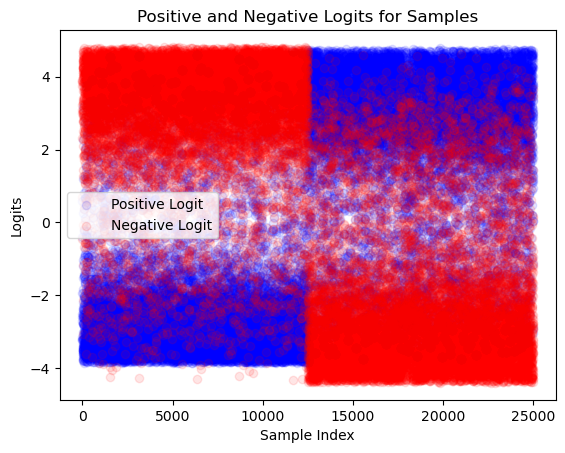

In [10]:
# plot keys as x-axis and positive/negative logits as y-axis
plt.scatter(keys, [p[0] for p in logits], label='Positive Logit', color='blue',alpha=0.1)
plt.scatter(keys, [p[1] for p in logits], label='Negative Logit', color='red',alpha=0.1)
plt.xlabel('Sample Index')
plt.ylabel('Logits')
plt.title('Positive and Negative Logits for Samples')
plt.legend()

In [11]:
# Next: Remove all samples whose original, rewrite, or rewrite-of-rewrite tokenized length exceeds the context window of 512

# Tokenize the original, rewrite, and rewritten rewrite texts
original_lengths = []
rewrite_lengths = []
rewritten_lengths = []

for key in tqdm(keys):
    original_text = data[key]["completions"]["original"]
    rewrite_text = data[key]["completions"]["rewrite"]
    rewritten_text = data[key]["completions"]["rewritten rewrite"]

    original_length = len(sentiment_tokenizer.tokenize(original_text))
    rewrite_length = len(sentiment_tokenizer.tokenize(rewrite_text))
    rewritten_length = len(sentiment_tokenizer.tokenize(rewritten_text))

    original_lengths.append(original_length)
    rewrite_lengths.append(rewrite_length)
    rewritten_lengths.append(rewritten_length)

# Convert lengths to numpy arrays
original_lengths = np.array(original_lengths)
rewrite_lengths = np.array(rewrite_lengths)
rewritten_lengths = np.array(rewritten_lengths)

# Check which samples exceed the length limit
length_limit = 512
valid_samples_mask = (original_lengths <= length_limit) & (rewrite_lengths <= length_limit) & (rewritten_lengths <= length_limit)
                                                                                               
# Filter valid samples
valid_samples_indices = np.where(valid_samples_mask)[0]
filtered_data = {key: data[key] for key in valid_samples_indices}

# Print the number of valid samples
print("Number of valid samples:", len(filtered_data))

100%|██████████| 25000/25000 [02:32<00:00, 164.38it/s]

Number of valid samples: 19378


In [12]:
# print how many original, rewrite, and rewritten lengths are invalid
print("Invalid original lengths:", np.sum(original_lengths > length_limit))
print("Invalid rewrite lengths:", np.sum(rewrite_lengths > length_limit))
print("Invalid rewritten lengths:", np.sum(rewritten_lengths > length_limit))
print("Total invalid lengths:", np.sum(original_lengths > length_limit) + np.sum(rewrite_lengths > length_limit) + np.sum(rewritten_lengths > length_limit))

Invalid original lengths: 3669
Invalid rewrite lengths: 2487
Invalid rewritten lengths: 1736
Total invalid lengths: 7892


In [13]:
# print first 2 valid samples
for key in list(filtered_data.keys())[:2]:
    print(f"{key}:")
    print(json.dumps(filtered_data[key], indent=4))

0:
{
    "w_original": true,
    "completions": {
        "original": "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered \"controversial\" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered por

In [14]:
# Next: Create the base dataset.

def create_groups(filtered_data, length_threshold=None, Distilbert_sentiment_label=True):
    long_positive_samples = []
    long_negative_samples = []
    short_positive_samples = []
    short_negative_samples = []

    # set a length threshold to be the median character length
    if length_threshold is None:
        lengths = [len(filtered_data[key]["completions"]["original"]) for key in filtered_data.keys()]
        length_threshold = np.median(lengths)
        print("Length threshold:", length_threshold)

    for key in tqdm(filtered_data.keys()):
        original_text = filtered_data[key]["completions"]["original"]
        original_length = len(original_text)

        # Determine the sentiment label
        if Distilbert_sentiment_label:
            positive_logit = filtered_data[key]["distilbert-base-uncased-finetuned-sst-2-english_positive_logit"]["original"]
            positive_logits = [filtered_data[key]["distilbert-base-uncased-finetuned-sst-2-english_positive_logit"]["original"] for key in filtered_data.keys()]
            positive_logit_threshold = np.mean(positive_logits)
            sentiment_label = positive_logit >= positive_logit_threshold
        else:
            sentiment_label = key >= 12500

        # Determine the length label
        length_label = int(original_length > length_threshold)

        # Append to appropriate lists
        if length_label == 1 and sentiment_label == 1:
            long_positive_samples.append(key)
        elif length_label == 1 and sentiment_label == 0:
            long_negative_samples.append(key)
        elif length_label == 0 and sentiment_label == 1:
            short_positive_samples.append(key)
        else:
            short_negative_samples.append(key)

    return long_positive_samples, long_negative_samples, short_positive_samples, short_negative_samples, length_threshold

long_positive_samples, long_negative_samples, short_positive_samples, short_negative_samples, length_threshold = create_groups(filtered_data, Distilbert_sentiment_label=Distilbert_sentiment_label)

Length threshold: 867.0


100%|██████████| 19378/19378 [01:06<00:00, 292.59it/s]


In [15]:
print("Counts in each group before sampling:")
print(f"Group (long=1, positive=1): {len(long_positive_samples)}")
print(f"Group (long=1, positive=0): {len(long_negative_samples)}")
print(f"Group (long=0, positive=1): {len(short_positive_samples)}")
print(f"Group (long=0, positive=0): {len(short_negative_samples)}")

# Find the minimum count among the four groups
min_count = min(len(long_positive_samples), len(long_negative_samples), len(short_positive_samples), len(short_negative_samples))
print(min_count)

# Step 3: Sample without replacement from each group to create the base dataset
long_positive_sampled = np.random.choice(long_positive_samples, min_count, replace=False)
long_negative_sampled = np.random.choice(long_negative_samples, min_count, replace=False)
short_positive_sampled = np.random.choice(short_positive_samples, min_count, replace=False)
short_negative_sampled = np.random.choice(short_negative_samples, min_count, replace=False)

# Step 4: Combine sampled data into new dataset
base_keys = np.concatenate((long_positive_sampled, long_negative_sampled, short_positive_sampled, short_negative_sampled))
# sort the keys
base_keys = sorted(base_keys.tolist())
print(base_keys[:5])
base_dataset = {key: filtered_data[key] for key in base_keys}

# Print the number of samples in the base dataset
print("Number of samples in the base dataset:", len(base_dataset))

# check the process worked correctly
assert len(base_dataset) == 4 * min_count, "Base dataset size is incorrect."
alt_base_dataset = {key: data[key] for key in base_keys}
assert alt_base_dataset == base_dataset, "Base dataset does not match alternative construction."

# Pring the first 2 samples of the base dataset
for key in list(base_dataset.keys())[:2]:
    print(f"{key}:")
    print(json.dumps(base_dataset[key], indent=4))

Counts in each group before sampling:
Group (long=1, positive=1): 4574
Group (long=1, positive=0): 5107
Group (long=0, positive=1): 4931
Group (long=0, positive=0): 4766
4574
[0, 2, 4, 6, 7]
Number of samples in the base dataset: 18296
0:
{
    "w_original": true,
    "completions": {
        "original": "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered \"controversial\" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politi

In [16]:
save_dir = data_dir / "synthetic"  if Distilbert_sentiment_label else data_dir / "synthetic_orig_labels"

In [17]:
# Save this base dataset for future use, keeping original name
save_file = filename.strip(".jsonl") + "_filtered.jsonl"
save_path = save_dir / save_file

def save_dataset(dataset,save_path):
    # If it already exists, delete it
    if (save_path).exists():
        os.remove(save_path)

    # make sure .jsonl
    assert save_path.suffix == ".jsonl", "Save path must have .jsonl extension."
    with open(save_path, "w") as f:
        for key in dataset.keys():
            json.dump(dataset[key], f)
            f.write("\n")

    # Make sure the permissions are read-only for everyone
    os.chmod(save_path, 0o444)

    # Get the GID of the group by its name
    group_name = "veitch-lab"
    gid = grp.getgrnam(group_name).gr_gid

    # Change the group of the file (leave UID unchanged by passing -1)
    os.chown(save_path, -1, gid)

save_dataset(base_dataset, save_path)

In [18]:
# Next, create datasets with increasing correlation between positive and long samples

print("Counts in each group after filtering:")
print(f"Group (long=1, positive=1): {len(long_positive_sampled)}")
print(f"Group (long=1, positive=0): {len(long_negative_sampled)}")
print(f"Group (long=0, positive=1): {len(short_positive_sampled)}")
print(f"Group (long=0, positive=0): {len(short_negative_sampled)}")

Counts in each group after filtering:
Group (long=1, positive=1): 4574
Group (long=1, positive=0): 4574
Group (long=0, positive=1): 4574
Group (long=0, positive=0): 4574


In [19]:
# Now we can create datasets with increasing correlation

def get_counts(N, max_per_group):
    # Base probabilities
    P_positive = 0.5
    P_negative = 0.5

    counts = []

    # Loop through each desired correlation level
    for i in range(11):
        P_long_given_positive = 0.5 + i * 0.05
        P_long_given_negative = 0.5 - i * 0.05

        # Calculate joint probabilities
        P_pos_long = P_positive * P_long_given_positive
        P_pos_short = P_positive * (1 - P_long_given_positive)
        P_neg_long = P_negative * P_long_given_negative
        P_neg_short = P_negative * (1 - P_long_given_negative)

        # Calculate sample counts
        n_long_positive = int(N * P_pos_long)
        n_short_positive = int(N * P_pos_short)
        n_long_negative = int(N * P_neg_long)
        n_short_negative = int(N * P_neg_short)
        counts.append((n_long_positive, n_long_negative, n_short_positive, n_short_negative))
    
    # convert to numpy array for easier manipulation
    counts = np.array(counts)
    max_groups = counts.max(axis=1)
    # Ensure that counts do not exceed max_per_group, while maintaining proportions
    counts = (counts / max_groups[:, None]) * max_per_group
    return counts.astype(int)

# Get counts for a sample size of len(base_dataset)
print("Base dataset size:", len(base_dataset))
print("Minimum count per group:", min_count)
counts = get_counts(len(base_dataset), min_count)
print("Counts for each correlation level")
for i, count in enumerate(counts):
    print(f"Correlation level {i}: {count}")
    print(f"Total samples: {sum(count)}")

Base dataset size: 18296
Minimum count per group: 4574
Counts for each correlation level
Correlation level 0: [4574 4574 4574 4574]
Total samples: 18296
Correlation level 1: [4574 3742 3742 4574]
Total samples: 16632
Correlation level 2: [4574 3049 3049 4574]
Total samples: 15246
Correlation level 3: [4574 2462 2462 4574]
Total samples: 14072
Correlation level 4: [4574 1960 1960 4574]
Total samples: 13068
Correlation level 5: [4574 1524 1524 4574]
Total samples: 12196
Correlation level 6: [4574 1143 1143 4574]
Total samples: 11434
Correlation level 7: [4574  807  807 4574]
Total samples: 10762
Correlation level 8: [4574  507  507 4574]
Total samples: 10162
Correlation level 9: [4574  240  240 4574]
Total samples: 9628
Correlation level 10: [4574    0    0 4574]
Total samples: 9148


In [20]:
# To ensure that each dataset has the same number of samples, we reduce the number of samples in earlier datasets
# to match the smallest dataset size
smallest_sample_size = np.min(counts.sum(axis=1))
print("Smallest sample size across correlation levels:", smallest_sample_size)

# Adjust counts to ensure all datasets have the same number of samples
adjusted_counts = counts * (smallest_sample_size / counts.sum(axis=1)[:, None])
adjusted_counts = adjusted_counts.astype(int)

# Check that all counts are valid
# for count in counts:
#     assert count.sum() == smallest_sample_size, "Counts do not sum to the smallest sample size."

print("Adjusted counts for each correlation level")
for i, count in enumerate(adjusted_counts):
    print(f"Correlation level {i}: {count}")
    print(f"Total samples: {sum(count)}")

# print table of proprtions
print("Proportions of each group:")
for i, count in enumerate(adjusted_counts):
    total = sum(count)
    proportions = count / total
    print(f"Correlation level {i}: {np.round(proportions,3)}")

print("True proportions:")
P_positive = 0.5
P_negative = 0.5
for i in range(11):
    P_long_given_positive = 0.5 + i * 0.05
    P_long_given_negative = 0.5 - i * 0.05

    # Calculate joint probabilities
    P_pos_long = np.round(P_positive * P_long_given_positive,3)
    P_pos_short = np.round(P_positive * (1 - P_long_given_positive),3)
    P_neg_long = np.round(P_negative * P_long_given_negative,3)
    P_neg_short = np.round(P_negative * (1 - P_long_given_negative),3)

    print(f"Correlation level {i}: {[P_pos_long, P_neg_long, P_pos_short, P_neg_short]}")

Smallest sample size across correlation levels: 9148
Adjusted counts for each correlation level
Correlation level 0: [2287 2287 2287 2287]
Total samples: 9148
Correlation level 1: [2515 2058 2058 2515]
Total samples: 9146
Correlation level 2: [2744 1829 1829 2744]
Total samples: 9146
Correlation level 3: [2973 1600 1600 2973]
Total samples: 9146
Correlation level 4: [3201 1372 1372 3201]
Total samples: 9146
Correlation level 5: [3430 1143 1143 3430]
Total samples: 9146
Correlation level 6: [3659  914  914 3659]
Total samples: 9146
Correlation level 7: [3888  685  685 3888]
Total samples: 9146
Correlation level 8: [4117  456  456 4117]
Total samples: 9146
Correlation level 9: [4345  228  228 4345]
Total samples: 9146
Correlation level 10: [4574    0    0 4574]
Total samples: 9148
Proportions of each group:
Correlation level 0: [0.25 0.25 0.25 0.25]
Correlation level 1: [0.275 0.225 0.225 0.275]
Correlation level 2: [0.3 0.2 0.2 0.3]
Correlation level 3: [0.325 0.175 0.175 0.325]
Correla

In [21]:
print("Adjusted counts:")
print(adjusted_counts)

Adjusted counts:
[[2287 2287 2287 2287]
 [2515 2058 2058 2515]
 [2744 1829 1829 2744]
 [2973 1600 1600 2973]
 [3201 1372 1372 3201]
 [3430 1143 1143 3430]
 [3659  914  914 3659]
 [3888  685  685 3888]
 [4117  456  456 4117]
 [4345  228  228 4345]
 [4574    0    0 4574]]


In [22]:
# Now we can create the datasets with increasing correlation

def create_correlated_datasets(base_dataset, adjusted_counts, filtered_groups):
    long_positive_filtered, long_negative_filtered, short_positive_filtered, short_negative_sampled = filtered_groups
    datasets = []
    
    for i, (n_long_positive, n_long_negative, n_short_positive, n_short_negative) in enumerate(adjusted_counts):
        long_positive = np.random.choice(long_positive_filtered, n_long_positive, replace=False)
        long_negative = np.random.choice(long_negative_filtered, n_long_negative, replace=False)
        short_positive = np.random.choice(short_positive_filtered, n_short_positive, replace=False)
        short_negative = np.random.choice(short_negative_sampled, n_short_negative, replace=False)

        # Combine sampled data into new dataset
        correlated_keys = np.concatenate((long_positive, long_negative, short_positive, short_negative))
        correlated_keys = sorted(correlated_keys.tolist())
        correlated_dataset = {key: base_dataset[key] for key in correlated_keys}
        datasets.append(correlated_dataset)
    return datasets

filtered_groups = (long_positive_sampled, long_negative_sampled, short_positive_sampled, short_negative_sampled)
correlated_datasets = create_correlated_datasets(base_dataset, adjusted_counts, filtered_groups)

In [23]:
# Save each correlated dataset
for i, dataset in enumerate(correlated_datasets):
    save_file = filename.strip(".jsonl") + f"_correlated_{i}.jsonl"
    save_path = save_dir / "positive_long" / save_file
    save_dataset(dataset, save_path)

In [24]:
# Now do the same thing, but with increasing correlation between negative and long samples
# This should be possible by just swapping the columns in the adjusted_counts

negative_counts = adjusted_counts[:, [2, 3, 0, 1]]
print(negative_counts)

[[2287 2287 2287 2287]
 [2058 2515 2515 2058]
 [1829 2744 2744 1829]
 [1600 2973 2973 1600]
 [1372 3201 3201 1372]
 [1143 3430 3430 1143]
 [ 914 3659 3659  914]
 [ 685 3888 3888  685]
 [ 456 4117 4117  456]
 [ 228 4345 4345  228]
 [   0 4574 4574    0]]


In [25]:
# save these negative correlated datasets
negative_correlated_datasets = create_correlated_datasets(base_dataset, negative_counts, filtered_groups)

# Save each correlated dataset
for i, dataset in enumerate(negative_correlated_datasets):
    save_file = filename.strip(".jsonl") + f"_correlated_negative_{i}.jsonl"
    save_path = save_dir / "negative_long" / save_file
    save_dataset(dataset, save_path)